In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set the root paths (update these to your local paths)
input_root = '/home/msiau/data/tmp/agarciat/DIV2K'
output_root = '/home/msiau/data/tmp/agarciat/DIV2K_processed'

# HR patch size (Height, Width)
hr_patch_size = (288, 288)  # You can change this value as needed

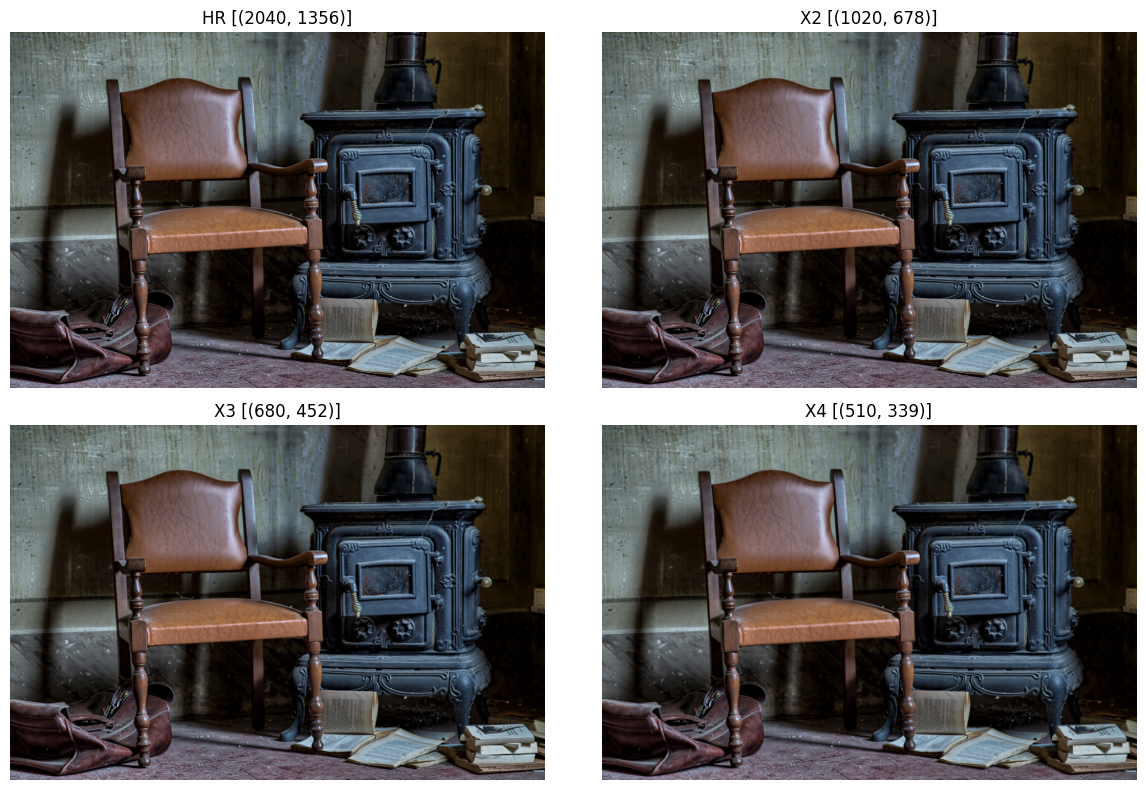

In [4]:
def display_random_images():
    # Select a random HR image from the training HR folder.
    hr_dir = os.path.join(input_root, 'DIV2K_train_HR')
    filenames = [f for f in os.listdir(hr_dir) if f.endswith('.png') or f.endswith('.jpg')]
    random_file = random.choice(filenames)
    
    # Open the HR image.
    hr_img = Image.open(os.path.join(hr_dir, random_file))
    
    # Get the base name without extension for modifying LR filenames
    base_name = os.path.splitext(random_file)[0]
    
    # Open the corresponding LR images from the bicubic folder.
    lr2_path = os.path.join(input_root, 'DIV2K_train_LR_bicubic', 'X2', f"{base_name}x2.png")
    lr3_path = os.path.join(input_root, 'DIV2K_train_LR_bicubic', 'X3', f"{base_name}x3.png")
    lr4_path = os.path.join(input_root, 'DIV2K_train_LR_bicubic', 'X4', f"{base_name}x4.png")
    
    lr2_img = Image.open(lr2_path)
    lr3_img = Image.open(lr3_path)
    lr4_img = Image.open(lr4_path)
    
    # Plot the images in a 2x2 grid.
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(hr_img)
    plt.title(f'HR [{hr_img.size}]')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(lr2_img)
    plt.title(f'X2 [{lr2_img.size}]')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(lr3_img)
    plt.title(f'X3 [{lr3_img.size}]')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(lr4_img)
    plt.title(f'X4 [{lr4_img.size}]')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random images
display_random_images()

In [10]:
# Updated Cell 4: Patch Extraction Functions and Processing Loop with Divisibility and Padding Considerations

from PIL import ImageOps

def extract_and_save_patches(hr_image_path, lr_bicubic_paths, lr_unknown_paths,
                             out_hr_dir, out_lr_bicubic_dirs, out_lr_unknown_dirs,
                             patch_size, scale_factors=[2, 3, 4], pad_if_needed=False):
    """
    Extract patches from an HR image and the corresponding LR images for each scale.
    Two strategies are available:
      - If pad_if_needed=False (default): Only extract patches that fully fit into the image,
        discarding any border pixels that don't complete a full patch.
      - If pad_if_needed=True: Pad the HR image (and the LR images) so that the dimensions
        become an exact multiple of patch_size. Reflection padding is used.
    """
    # Open HR image.
    hr_img = Image.open(hr_image_path)
    hr_width, hr_height = hr_img.size
    patch_h, patch_w = patch_size

    # Determine remainders to see if the HR image dimensions are divisible by patch_size.
    rem_w = hr_width % patch_w
    rem_h = hr_height % patch_h
    if pad_if_needed and (rem_w != 0 or rem_h != 0):
        # Compute required padding amounts.
        pad_right = (patch_w - rem_w) if rem_w != 0 else 0
        pad_bottom = (patch_h - rem_h) if rem_h != 0 else 0
        hr_img = ImageOps.expand(hr_img, border=(0, 0, pad_right, pad_bottom), fill='reflect')
        hr_width, hr_height = hr_img.size  # Update dimensions after padding.
    else:
        # Crop the image to only consider the complete patches.
        hr_width = hr_width - rem_w
        hr_height = hr_height - rem_h
        hr_img = hr_img.crop((0, 0, hr_width, hr_height))

    num_patches = 0
    # Slide a window over the HR image to extract patches.
    for top in range(0, hr_height, patch_h):
        for left in range(0, hr_width, patch_w):
            # Extract HR patch.
            hr_patch = hr_img.crop((left, top, left + patch_w, top + patch_h))
            base_name = os.path.splitext(os.path.basename(hr_image_path))[0]
            patch_filename = f"{base_name}_patch_{num_patches}.png"
            hr_patch.save(os.path.join(out_hr_dir, patch_filename))
            
            # For each scale factor, compute and save the corresponding LR patch.
            for scale in scale_factors:
                lr_patch_w = patch_w // scale
                lr_patch_h = patch_h // scale
                
                # Process LR bicubic image.
                lr_bicubic_img = Image.open(lr_bicubic_paths[scale])
                lr_width, lr_height = lr_bicubic_img.size
                lr_rem_w = lr_width % lr_patch_w
                lr_rem_h = lr_height % lr_patch_h
                if pad_if_needed and (lr_rem_w != 0 or lr_rem_h != 0):
                    lr_pad_right = (lr_patch_w - lr_rem_w) if lr_rem_w != 0 else 0
                    lr_pad_bottom = (lr_patch_h - lr_rem_h) if lr_rem_h != 0 else 0
                    lr_bicubic_img = ImageOps.expand(lr_bicubic_img, border=(0, 0, lr_pad_right, lr_pad_bottom), fill='reflect')
                    lr_width, lr_height = lr_bicubic_img.size
                else:
                    lr_bicubic_img = lr_bicubic_img.crop((0, 0, lr_width - lr_rem_w, lr_height - lr_rem_h))
                
                # Compute corresponding coordinates in the LR image.
                lr_left = left // scale
                lr_top = top // scale
                lr_bicubic_patch = lr_bicubic_img.crop((lr_left, lr_top, lr_left + lr_patch_w, lr_top + lr_patch_h))
                lr_bicubic_patch.save(os.path.join(out_lr_bicubic_dirs[scale], patch_filename))
                
                # Process LR unknown image similarly.
                lr_unknown_img = Image.open(lr_unknown_paths[scale])
                lr_width, lr_height = lr_unknown_img.size
                lr_rem_w = lr_width % lr_patch_w
                lr_rem_h = lr_height % lr_patch_h
                if pad_if_needed and (lr_rem_w != 0 or lr_rem_h != 0):
                    lr_pad_right = (lr_patch_w - lr_rem_w) if lr_rem_w != 0 else 0
                    lr_pad_bottom = (lr_patch_h - lr_rem_h) if lr_rem_h != 0 else 0
                    lr_unknown_img = ImageOps.expand(lr_unknown_img, border=(0, 0, lr_pad_right, lr_pad_bottom), fill='reflect')
                    lr_width, lr_height = lr_unknown_img.size
                else:
                    lr_unknown_img = lr_unknown_img.crop((0, 0, lr_width - lr_rem_w, lr_height - lr_rem_h))
                
                lr_unknown_patch = lr_unknown_img.crop((lr_left, lr_top, lr_left + lr_patch_w, lr_top + lr_patch_h))
                lr_unknown_patch.save(os.path.join(out_lr_unknown_dirs[scale], patch_filename))
            
            num_patches += 1

def process_dataset(dataset_type='train', pad_if_needed=False):
    """
    Process the dataset (train or valid) by extracting patches.
    The corresponding LR images (bicubic and unknown) are handled for each scale.
    """
    print(f"Processing {dataset_type} dataset with pad_if_needed={pad_if_needed}...")
    
    # Input directories.
    hr_dir = os.path.join(input_root, f'DIV2K_{dataset_type}_HR')
    lr_bicubic_dir = os.path.join(input_root, f'DIV2K_{dataset_type}_LR_bicubic')
    lr_unknown_dir = os.path.join(input_root, f'DIV2K_{dataset_type}_LR_unknown')
    
    # Output directories.
    out_hr_dir = os.path.join(output_root, f'DIV2K_{dataset_type}_HR')
    out_lr_bicubic_dirs = {scale: os.path.join(output_root, f'DIV2K_{dataset_type}_LR_bicubic', f'X{scale}')
                           for scale in [2, 3, 4]}
    out_lr_unknown_dirs = {scale: os.path.join(output_root, f'DIV2K_{dataset_type}_LR_unknown', f'X{scale}')
                           for scale in [2, 3, 4]}
    
    # Process each HR image.
    for img_file in sorted(os.listdir(hr_dir)):
        if not (img_file.endswith('.png') or img_file.endswith('.jpg')):
            continue
        hr_image_path = os.path.join(hr_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        lr_bicubic_paths = {scale: os.path.join(lr_bicubic_dir, f'X{scale}', f"{base_name}x{scale}.png")
                            for scale in [2, 3, 4]}
        lr_unknown_paths = {scale: os.path.join(lr_unknown_dir, f'X{scale}', f"{base_name}x{scale}.png")
                            for scale in [2, 3, 4]}
        
        extract_and_save_patches(hr_image_path, lr_bicubic_paths, lr_unknown_paths,
                                 out_hr_dir, out_lr_bicubic_dirs, out_lr_unknown_dirs,
                                 patch_size=hr_patch_size, pad_if_needed=pad_if_needed)
        print(f"Processed {img_file}")

# Process both the training and validation sets.
# Set pad_if_needed to True if you want to pad images to cover the entire area,
# or leave it as False to discard border regions that don't form a full patch.
process_dataset('train', pad_if_needed=False)
process_dataset('valid', pad_if_needed=False)

Processing train dataset with pad_if_needed=False...
Processed 0001.png
Processed 0002.png
Processed 0003.png
Processed 0004.png
Processed 0005.png
Processed 0006.png
Processed 0007.png
Processed 0008.png
Processed 0009.png
Processed 0010.png
Processed 0011.png
Processed 0012.png
Processed 0013.png
Processed 0014.png
Processed 0015.png
Processed 0016.png
Processed 0017.png
Processed 0018.png
Processed 0019.png
Processed 0020.png
Processed 0021.png
Processed 0022.png
Processed 0023.png
Processed 0024.png
Processed 0025.png
Processed 0026.png
Processed 0027.png
Processed 0028.png
Processed 0029.png
Processed 0030.png
Processed 0031.png
Processed 0032.png
Processed 0033.png
Processed 0034.png
Processed 0035.png
Processed 0036.png
Processed 0037.png
Processed 0038.png
Processed 0039.png
Processed 0040.png
Processed 0041.png
Processed 0042.png
Processed 0043.png
Processed 0044.png
Processed 0045.png
Processed 0046.png
Processed 0047.png
Processed 0048.png
Processed 0049.png
Processed 0050.p

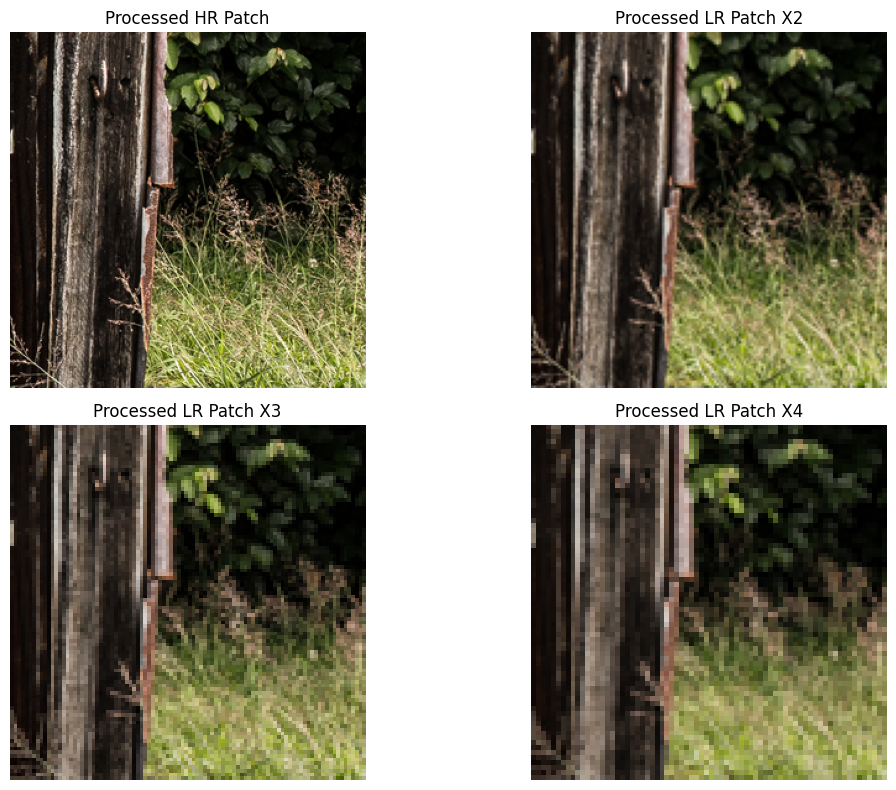

In [6]:
def display_random_processed_patches():
    # Select a random processed HR patch from the output train HR folder.
    processed_hr_dir = os.path.join(output_root, 'DIV2K_train_HR')
    filenames = [f for f in os.listdir(processed_hr_dir) if f.endswith('.png') or f.endswith('.jpg')]
    if not filenames:
        print("No processed patches found in:", processed_hr_dir)
        return
    random_file = random.choice(filenames)
    
    # Open the processed HR patch.
    hr_patch = Image.open(os.path.join(processed_hr_dir, random_file))
    
    # Open the corresponding LR patches from the LR_bicubic folders.
    lr2_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X2', random_file))
    lr3_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X3', random_file))
    lr4_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X4', random_file))
    
    # Plot the patches in a 2x2 grid.
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(hr_patch)
    plt.title('Processed HR Patch')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(lr2_patch)
    plt.title('Processed LR Patch X2')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(lr3_patch)
    plt.title('Processed LR Patch X3')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(lr4_patch)
    plt.title('Processed LR Patch X4')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random processed patches
display_random_processed_patches()
